# A/B-тестирование изменений, связанных с внедрением улучшенной рекомендательной системы

**`Назначение теста:`** тестирование изменений, связанных с внедрением улучшенной рекомендательной системы.

**`Цель исследования` — продемонстрировать наличие или отсутствие ожидаемого эффекта:**

За 14 дней с момента регистрации пользователи показали улучшение каждой метрики не менее, чем на 10%:

    - конверсии в просмотр карточек товаров — событие `product_page`,
    
    - просмотры корзины — `product_cart`,
    
    - покупки — `purchase`.
    
**`Задачи:`**

1. Провести предобработку данных;


2. Оценить корректность проведения теста:

    - Проверить соответствие данных требованиям ТЗ. 
    - Убедиться, что время проведения теста не совпадает с маркетинговыми и другими активностями.
    - Убедиться, что аудитория теста не пересекаестя с аудиторией конкурирующего теста и расвномерна распределена по тестовым группам.


3. Провести исследовательский анализ данных и построить воронки событий;


4. Оценить результаты A/B-тестирования с помощью z-теста.

**`Техническое задание:`**

1. Название теста: recommender_system_test;


2. Группы: А — контрольная, B — новая платёжная воронка;


3. Дата запуска: 2020-12-07;


4. Дата остановки набора новых пользователей: 2020-12-21;


5. Дата остановки: 2021-01-04;


6. Аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;


7. Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;


8. Ожидаемое количество участников теста: 6000.


9. Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**`Источники данных:`** материалы курса "Аналитика данных" Яндекс Практикума

## Предобработка данных / оценка корректности проведения теста

In [1]:
# импортируем библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from plotly import graph_objects as go
from scipy import stats as st
import math as mth

### Первичные данные таблиц

In [2]:
# Открываем таблицу действий новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
final_ab_events = pd.read_csv(r"C:\Users\Lenovo\Desktop\Github проекты\final_ab_events.csv")
display(final_ab_events)
print()
final_ab_events.info()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


- Обнаружены пропуски в `'details'`;
- Нужно изменить тип данных `'event_dt'.`

In [3]:
# Открываем календарь маркетинговых событий на 2020 год
ab_project_marketing_events = pd.read_csv(r"C:\Users\Lenovo\Desktop\Github проекты\ab_project_marketing_events.csv")
display(ab_project_marketing_events)
print()
ab_project_marketing_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


- Нужно изменить тип данных `'start_dt'` и `'finish_dt'`.

In [4]:
# Открываем таблицу с пользователями, зарегистрировавшимися с 7 до 21 декабря 2020 года
final_ab_new_users = pd.read_csv(r"C:\Users\Lenovo\Desktop\Github проекты\final_ab_new_users.csv") 
display(final_ab_new_users)
print()
final_ab_new_users.info()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


- Нужно изменить тип данных `'first_date'`.

In [5]:
# Открываем таблицу с участниками тестов
final_ab_participants = pd.read_csv(r"C:\Users\Lenovo\Desktop\Github проекты\final_ab_participants.csv")
display(final_ab_participants)
print()
final_ab_participants.info()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


### Преобразование типов данных

In [6]:
# изменяем тип данных c object на datetime
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

### Проверка на соответствие временным рамкам набора участников и длительности теста

In [7]:
# определение даты запуска теста 
final_ab_new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

- **Дата запуска теста верная (верная: `2020-12-07`)**

In [8]:
# определение даты остановки набора новых пользователей
final_ab_new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

- **Дата остановки набора новых пользователей неверная (верная: `2020-12-21`). Нужно сделать срез.**

In [9]:
# определение даты остановки теста 
final_ab_events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

- **Дата остановки теста неверная (верная: `2021-01-04`)**

In [10]:
# посмотрим дату, по которой нужно фильтровать остановку набора пользователей в соответствии с горизонтом событий = 14
observation_date = datetime(20, 12, 30).date()
horizon_days = 14
last_suitable_reg_date = observation_date - timedelta(days = horizon_days - 1)
last_suitable_reg_date

datetime.date(20, 12, 17)

- **В соответствии с horizon_days = 14 и выявленной датой остановки теста "2020-12-30", дата остановки набора пользователей должна быть изменена на "2020-12-17".**

### Фильтруем данные по корректной дате остановки набора пользователей ''2020-12-17 00:00:00'' 

In [11]:
# Фильтруем данные
final_ab_new_users = final_ab_new_users[final_ab_new_users['first_date'] < '2020-12-17 00:00:00']

### Совпадение теста и маркетинговых событий 

**Начало периода АБ-теста:** 2020-12-07
    
**Завершение периода АБ-теста:** 2020-12-30

In [12]:
# маркетинговые события начавшиеся до периода, закончившиеся после
ab_project_marketing_events.query('start_dt < "2020-12-07" and finish_dt > "2020-12-30"')

,name,regions,start_dt,finish_dt


In [13]:
# маркетинговые события начавшиеся до периода, закончившиеся во время
ab_project_marketing_events.query('start_dt < "2020-12-07" and  "2020-12-07" <= finish_dt <= "2020-12-30"')

,name,regions,start_dt,finish_dt


In [14]:
# маркетинговые события начавшиеся во время периода, закончившиеся после
ab_project_marketing_events.query('"2020-12-07" <= start_dt <= "2020-12-30" and finish_dt > "2020-12-30"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [15]:
# маркетинговые события начавшиеся во время периода, закончившиеся во время периода
ab_project_marketing_events.query('"2020-12-07" <= start_dt <= "2020-12-30" and  "2020-12-07" <= finish_dt <= "2020-12-30"')

,name,regions,start_dt,finish_dt


- **Период проведения теста `'recommender_system_test'` пересекается с 2мя маркетинговыми событиями: `'Christmas&New Year Promo'` и `'CIS New Year Gift Lottery'`;**


- **Это может сказаться на результатах АБ-теста. Следует мониторить данные от 2020-12-25 до 2020-12-30.**

### Проверка на явные дубликаты

In [16]:
# Проверяем таблицы на дубликаты
print(final_ab_events.duplicated().sum())
print()
print(ab_project_marketing_events.duplicated().sum())
print()
print(final_ab_new_users.duplicated().sum())
print()
final_ab_participants.duplicated().sum()

0

0

0



0

### Выявление пользователей, попавших в 2 группы теста 'recommender_system_test' одновременно

In [17]:
# Смотрим, какие есть уникальные тесты
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [18]:
# Делаем срез для работы с данными теста 'recommender_system_test'
final_ab_participants_1 = final_ab_participants.copy()
final_ab_participants_1 = final_ab_participants_1.query('ab_test == "recommender_system_test"')
final_ab_participants_1['ab_test'].unique()

array(['recommender_system_test'], dtype=object)

In [19]:
# объединяем уникальных пользователей из группы А и B теста 'recommender_system_test'
unique_user_id_1 = np.concatenate([final_ab_participants_1[final_ab_participants_1['group'] == 'A']['user_id'].unique(),
                                  final_ab_participants_1[final_ab_participants_1['group'] == 'B']['user_id'].unique()])

unique_user_id_1 = pd.DataFrame(unique_user_id_1, columns = ['unique_user_id_1'])

len(unique_user_id_1)

6701

In [20]:
# удаляем дубликаты пользователей из группы А и B теста 'recommender_system_test'
unique_user_id_1 = unique_user_id_1.drop_duplicates()
len(unique_user_id_1)

6701

- **Не обнаружены пользователи, участвующие в двух группах теста `'recommender_system_test'` одновременно.** 

### Выявление пользователей, попавших в 2 группы теста 'interface_eu_test' одновременно

In [21]:
# Делаем срез для работы с данными теста 'interface_eu_test'
final_ab_participants_2 = final_ab_participants.copy()
final_ab_participants_2 = final_ab_participants_2.query('ab_test == "interface_eu_test"')

# объединяем уникальных пользователей из группы А и B теста 'interface_eu_test'
unique_user_id_2 = np.concatenate([final_ab_participants_2[final_ab_participants_2['group'] == 'A']['user_id'].unique(),
                                  final_ab_participants_2[final_ab_participants_2['group'] == 'B']['user_id'].unique()])

unique_user_id_2 = pd.DataFrame(unique_user_id_2, columns = ['unique_user_id_2'])
len(unique_user_id_2)

11567

In [22]:
# удаляем дубликаты пользователей из группы А и B теста 'interface_eu_test'
unique_user_id_2 = unique_user_id_2.drop_duplicates()
len(unique_user_id_2)

11567

- **Не обнаружены пользователи, участвующие в двух группах теста `'interface_eu_test'` одновременно.** 

### Проверка на неявные дубликаты 

In [23]:
# Смотрим, сколько пользователей пересекается в тестах 'recommender_system_test' и 'interface_eu_test'
final_ab_participants.duplicated(subset=['user_id']).sum()

1602

- **Обнаружено 1602 дубликата по столбцу `'user_id'`. Это значит, что у обоих тестов (`'recommender_system_test'` и `'interface_eu_test'`) есть пересечения по пользователям.**
- **Тест `interface_eu_test` является конкурирующим и может нарушить результаты нашего.**

### Выявление пользователей, попавших в КОНТРОЛЬНЫЕ группы тестов 'recommender_system_test' и 'interface_eu_test' одновременно

In [24]:
# выбираем пользователей из тестов 'recommender_system_test' и 'interface_eu_test', состоящих в контрольных группах 
test_1_cont = final_ab_participants_1[(final_ab_participants_1['group'] == 'A')]
test_2_cont =  final_ab_participants_2[(final_ab_participants_2['group'] == 'A')]

# объединяем полученные выборки пользователей контрольных групп обоих тестов
test_common = test_1_cont.merge(test_2_cont, on = 'user_id')

# смотрим количество пересекающихся пользователей экспериментальных групп обоих тестов
len(test_common['user_id'].unique())

482

- Обнаружены пользователи, участвующие в контрольных группах обоих тестов.
- **Не будем их удалять т.к. пользователи из контрольных групп обоих тестов не видят никаких изменений и поэтому их пользовательская активность не должна измениться.** 

### Выявление пользователей, попавших в ЭКСПЕРИМЕНТАЛЬНЫЕ группы тестов 'recommender_system_test' и 'interface_eu_test' одновременно

In [25]:
# выбираем пользователей из тестов 'recommender_system_test' и 'interface_eu_test', состоящих в экспериментальных группах 
test_1 = final_ab_participants_1[(final_ab_participants_1['group'] == 'B')]
test_2 =  final_ab_participants_2[(final_ab_participants_2['group'] == 'B')]

# объединяем полученные выборки пользователей экспериментальных групп обоих тестов
test_common = test_1.merge(test_2, on = 'user_id')

# смотрим количество пересекающихся пользователей экспериментальных групп обоих тестов
len(test_common['user_id'].unique())

344

- Обнаружены пользователи, участвующие в экспериментальных группах обоих тестов.
- **Этих пользователей придётся удалить т.к. невозможно выявить, какое из 2ух экспериментальных нововведний повлияло на конверсию.** 

In [26]:
# исключаем из теста 'recommender_system_test' дублирующихся пользователей экспериментальных групп тестов 
final_ab_participants_1_drop = final_ab_participants_1[~final_ab_participants_1['user_id'].isin(test_common['user_id'])]

len(final_ab_participants_1_drop)

6357

### Выявление пользователей, попавших в ЭКСПЕРИМЕНТАЛЬНУЮ группу теста  'interface_eu_test' и одновременно в КОНТРОЛЬНУЮ группу теста 'recommender_system_test'

In [27]:
# выбираем пользователей из экспериментальной группы теста 'interface_eu_test' и котнрольной группы - 'recommender_system_test' 
test_1_cont = final_ab_participants_1[(final_ab_participants_1['group'] == 'A')]
test_2_exp =  final_ab_participants_2[(final_ab_participants_2['group'] == 'B')]

# объединяем полученные выборки пользователей эксп. 'interface_eu_test' и контр.'recommender_system_test'
test_common_1 = test_1_cont.merge(test_2_exp, on = 'user_id')

# смотрим количество пересекающихся пользователей эксп. 'interface_eu_test' и контр.'recommender_system_test'
len(test_common_1['user_id'].unique())

439

In [28]:
# исключаем из теста 'recommender_system_test' дублирующихся пользователей из экспериментальной группы теста 'interface_eu_test' и котнрольной группы - 'recommender_system_test'
final_ab_participants_1_drop = final_ab_participants_1_drop[~final_ab_participants_1_drop['user_id'].isin(test_common_1['user_id'])]

len(final_ab_participants_1_drop)

5918

- **`Из 6701 уник. пользователей, участвующих в тесте 'recommender_system_test' осталось 5918. Исключены пользователи, участвующие одновременно в экспериментальных группах тестов 'recommender_system_test' и 'interface_eu_test'. А также пользователи, участвующие в экспериментальной группе теста 'interface_eu_test' и контрольной группе - 'recommender_system_test'. `**

### Проверка на пропуски

In [29]:
# Проверяем, есть ли пропуски
final_ab_events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [30]:
# Смотрим, какие и сколько событий совершили пользователи в период с 7 декабря 2020 по 4 января 2021 года
events = final_ab_events.groupby('event_name').agg({'user_id': 'count'}).sort_values(by= 'user_id' , ascending=False).reset_index()
events.columns = ['event_name', 'number_events']
events

,event_name,number_events
0,login,189552
1,product_page,125563
2,purchase,62740
3,product_cart,62462


- В таблице `'final_ab_events'` есть данные о 4 уникальных событиях:  `'login'` - регистрация, `product_page`- конверсии в просмотр карточек товаров, `product_cart`- просмотры корзины, `'purchase'` - стоимость покупки в долларах.

- В столбце `'details'` — дополнительные данные об этих событиях.

- ** В таблице `'final_ab_events'` 377577 пропусков в столбце `'details'` невозможно заполнить вручную из-за специфичности данных.**

In [31]:
# Проверяем, есть ли пропуски в остальных таблицах
print(ab_project_marketing_events.isna().sum())
print()
print(final_ab_new_users.isna().sum())
print()
final_ab_participants.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

user_id       0
first_date    0
region        0
device        0
dtype: int64



user_id    0
group      0
ab_test    0
dtype: int64

- **Во всех остальных таблицах пропуски не обнаружены.**

### Проверка на содержание 15% новых пользователей из региона EU

In [32]:
# посмотрим, сколько пользователей и из каких регионов зарегистрировались с 7 до 21 декабря 2020 года
all_users_region = final_ab_new_users.groupby('region').agg({'user_id': 'count'}).sort_values(by= 'user_id' , ascending=False).reset_index()
all_users_region.columns = ['region', 'all_users']
all_users_region

,region,all_users
0,EU,26986
1,N.America,5262
2,APAC,1808
3,CIS,1806


In [33]:
# объединяем таблицу участников теста 'recommender_system_test' и таблицу пользователей, зарегистрировавшиеся с 7 до 21 декабря 2020 года. 
recsys_test_7_21 = final_ab_participants_1_drop.merge(final_ab_new_users, on='user_id')
recsys_test_7_21

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
2,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
3,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
4,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone
...,...,...,...,...,...,...
3798,94786EB776B45914,A,recommender_system_test,2020-12-14,APAC,Android
3799,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10,N.America,Android
3800,9D263B8EF15CF188,B,recommender_system_test,2020-12-16,N.America,Mac
3801,29C92313A98B1176,B,recommender_system_test,2020-12-07,APAC,Android


In [34]:
# смотрим, сколько пользователей от каждого региона участвуют в тесте 'recommender_system_test'
test_users_region = recsys_test_7_21.groupby('region').agg({'user_id': 'count'}).sort_values(by= 'user_id' , ascending=False).reset_index()
test_users_region.columns = ['region', 'test_users']
test_users_region ['part'] = round(test_users_region ['test_users']/test_users_region ['test_users'].sum() *100, 1)
test_users_region 

,region,test_users,part
0,EU,3575,94.0
1,N.America,148,3.9
2,APAC,43,1.1
3,CIS,37,1.0


- **Около `94% новых пользователей`, участвующих в тесте 'recommender_system_test', `из региона EU.`**
- **Остальные 6% из других регионов попали по ошибке, они могут помешать проведению теста.**

In [35]:
# Оставляем только пользователей, которые из региона EU
test_users_region_EU = recsys_test_7_21.query('region == "EU"')
test_users_region_EU

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
2,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
3,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
4,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone
...,...,...,...,...,...,...
3570,700E7D23A9A81AE3,B,recommender_system_test,2020-12-16,EU,Android
3571,A23B0A7FFF375BFF,B,recommender_system_test,2020-12-12,EU,Android
3572,91C3969B8A72B908,B,recommender_system_test,2020-12-09,EU,Android
3573,95401934D6D6D4FC,B,recommender_system_test,2020-12-13,EU,iPhone


In [36]:
# смотрим, сколько пользователей из региона EU попало в тест 'recommender_system_test'
test_from_all = all_users_region.merge(test_users_region , on='region')
test_from_all['test_from_all'] = round(test_from_all['test_users'] / test_from_all['all_users'] * 100, 1)
test_from_all.drop(columns = ['part'], axis = 1, inplace=True)
test_from_all

,region,all_users,test_users,test_from_all
0,EU,26986,3575,13.2
1,N.America,5262,148,2.8
2,APAC,1808,43,2.4
3,CIS,1806,37,2.0


- **`13,2% пользователей` из региона EU `попало в тест 'recommender_system_test'`, что не соответствует техническому заданию.**

In [37]:
# Объединяем таблицу с участниками теста 'recommender_system_test' и таблицу c событиями с 7 декабря 2020 по 30 декабря 2021 года
ab_test_events = final_ab_events.merge(test_users_region_EU, on='user_id', how = 'right')
ab_test_events['user_id'].nunique()

3575

In [38]:
ab_test_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13409 entries, 0 to 13408
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     13409 non-null  object        
 1   event_dt    11509 non-null  datetime64[ns]
 2   event_name  11509 non-null  object        
 3   details     1482 non-null   float64       
 4   group       13409 non-null  object        
 5   ab_test     13409 non-null  object        
 6   first_date  13409 non-null  datetime64[ns]
 7   region      13409 non-null  object        
 8   device      13409 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.0+ MB


- **`Не для всех отобранных пользователей в данных таблицы "final_ab_events" есть 'event_name' и 'event_dt'.`**

### Сколько участников теста c лайфтаймом событий <= 14 дней совершали действия

In [39]:
# отфильтруем события, лайфтайм которых > 14 дней и посчитаем пользователей
ab_test_events_14 = ab_test_events[(ab_test_events['event_dt'] - ab_test_events['first_date']).dt.days <= 14]
ab_test_events_14['user_id'].nunique()

1675

In [40]:
ab_test_events_14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10979 entries, 0 to 13408
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     10979 non-null  object        
 1   event_dt    10979 non-null  datetime64[ns]
 2   event_name  10979 non-null  object        
 3   details     1414 non-null   float64       
 4   group       10979 non-null  object        
 5   ab_test     10979 non-null  object        
 6   first_date  10979 non-null  datetime64[ns]
 7   region      10979 non-null  object        
 8   device      10979 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 857.7+ KB


- **`Теперь мы располагаем полными данными для исследования.`**

In [41]:
proc = ab_test_events_14['user_id'].nunique()/6000 * 100
print(f'Процент активных пользователей, участвующих в тесте "recommender_system_test", от ожидаемого кол-ва 6000 : {round(proc, 1)}%')

Процент активных пользователей, участвующих в тесте "recommender_system_test", от ожидаемого кол-ва 6000 : 27.9%


- **`Условие "ожидаемое количество участников теста: 6000" согласно ТЗ не выполняется.`**

# Выводы по блоку "Предобработка данных / оценка корректности проведения теста"

**`Какие фильтрации были проведены:`**

- **Фильтрация данных по дате остановки набора пользователей "2020-12-17 00:00:00" в соответствии с horizon_days = 14 и выявленной датой остановки теста "2020-12-30 23:36:33";**


- **Сделали срез для работы с данными интересующего теста 'recommender_system_test';**



- **Исключили из теста 'recommender_system_test' дублирующихся пользователей экспериментальных групп обоих тестов 'recommender_system_test' и 'interface_eu_test'. А также пользователей, участвующих в экспериментальной группе теста 'interface_eu_test' и контрольной группе - 'recommender_system_test';**


- **Оставили только пользователей, которые из региона EU, а пользователей из N.America, APAC и CIS, попавших по ошибке, удалили;**


- **Отфильтровали события, лайфтайм которых > 14 дней и пользователей, для которых не было данных 'event_name' и 'event_dt'.**

**`Результаты предобработки данных:`**

- Нет явных дубликатов;

- Обнаружено 1602 неявных дубликата в таблице "final_ab_participants" по столбцу 'user_id'. Согласно ТЗ проведена работы с ними;

- В таблице "final_ab_events" обнаружено 377577 пропусков в столбце 'details', которые невозможно заполнить вручную из-за специфичности данных;

- В остальных таблицах пропусков нет;

- Данные приведены к нужным типам;

- Названия столбцов имеют общепринятый вид.

**`Условия из ТЗ, которые НЕ выполнены:`**

- Предоставлено ограниченное количество данных исходя из выявленной `даты остановки теста`: '2020-12-30 23:36:33' (верная дата согласно ТЗ: 2020-01-04);


- В связи с чем проведена `фильтрация данных по дате остановки набора пользователей` "2020-12-17 00:00:00" в соответствии с horizon_days = 14 (верная дата согласно ТЗ: 2020-12-21);


- В тест отобрано 13,2% `пользователей из региона EU` (ожидаемое кол-во согласно ТЗ: 15%);


- Процент активных пользователей, участвующих в тесте "recommender_system_test", от `ожидаемого кол-ва 6000` : 27.9%.


- **Период проведения теста `'recommender_system_test'` пересекается с 2мя маркетинговыми событиями: `'Christmas&New Year Promo'` и `'CIS New Year Gift Lottery'`. Это может сказаться на результатах АБ-теста. Следует мониторить данные от 2020-12-25 до 2020-12-30.**

## Исследовательский анализ данных

###  Проверка на равномерность распределения пользователей по тестовым группам

In [42]:
# посмотрим, сколько пользователей в группах А и B теста 'recommender_system_test' совершали действия
ab_test_actions  = ab_test_events_14.groupby('group').agg({'user_id': 'nunique'}).sort_values(by= 'user_id' , ascending=False).reset_index()
ab_test_actions.columns = ['group', 'number_user']
ab_test_actions["proc"] = ab_test_actions['number_user']/ab_test_actions['number_user'].sum() * 100
ab_test_actions["proc"] = round(ab_test_actions["proc"])
ab_test_actions 

,group,number_user,proc
0,A,1145,68.0
1,B,530,32.0


- **Активные пользователи теста распределены по группам А и B неравномерно.**

### Распределение количества действий, совершаемых активными пользователями обеих групп А и В (абсолютные величины)

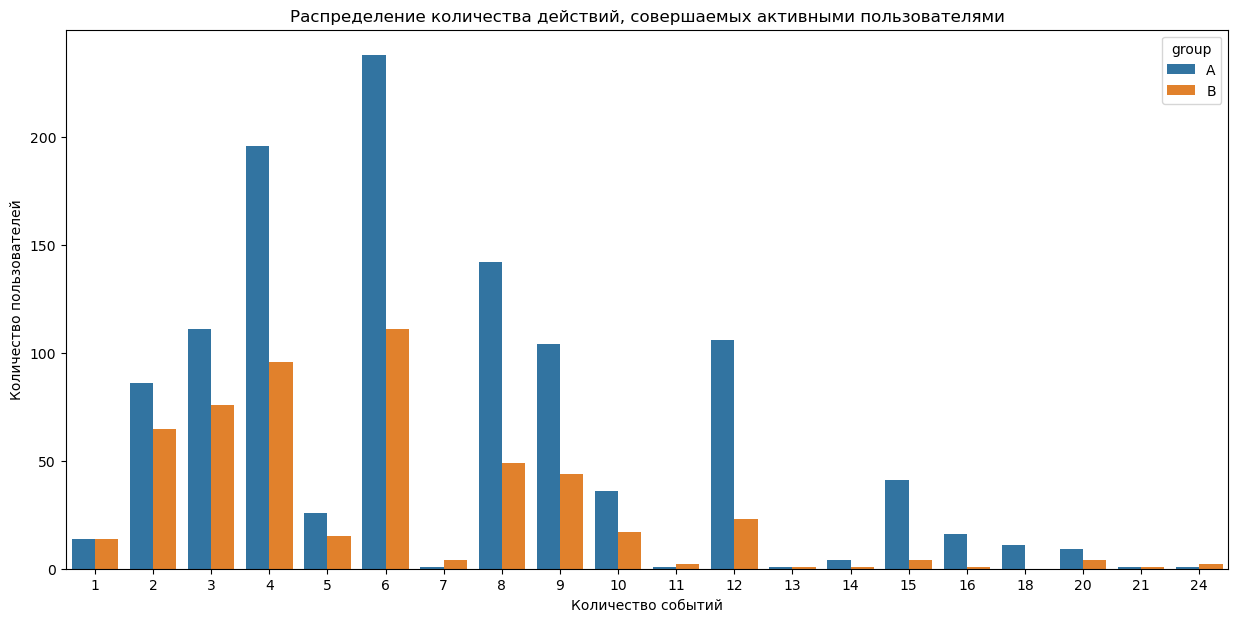

In [43]:
# считаем количество событий на пользователя в разрезе групп А и Б
events_per_user = ab_test_events_14.groupby(['user_id', 'group']).agg({'event_name': 'count'}).reset_index()
events_per_user.columns = ['user_id', 'group', 'number_event']

# строим гистограмму распределения количества событий, совершаемых пользователями обеих групп А и В
plt.figure(figsize = (15,7))
sns.countplot(data = events_per_user,
             x = 'number_event',
             hue = 'group')
plt.title('Распределение количества действий, совершаемых активными пользователями')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

- **Чаще всего пользователи обеих групп совершают 6 событий.** 

In [44]:
# Среднее и медианное кол-во событий группы пользователей A
mean_A = events_per_user.query('group == "A"')['number_event'].mean()
print(round(mean_A,1))
print()
median_A = events_per_user.query('group == "A"')['number_event'].median()
print(median_A)

6.9

6.0


In [45]:
# Среднее и медианное кол-во событий группы пользователей B
mean_B = events_per_user.query('group == "B"')['number_event'].mean()
print(round(mean_B,1))
print()
median_B = events_per_user.query('group == "B"')['number_event'].median()
print(median_B)

5.7

5.0


- **Среднее и медианное кол-во действий, совершаемых пользователи группы А выше, чем у пользователей группы B.**

### Соотношение каждого типа события от общего кол-ва для групп пользователей А и В (относительные величины)

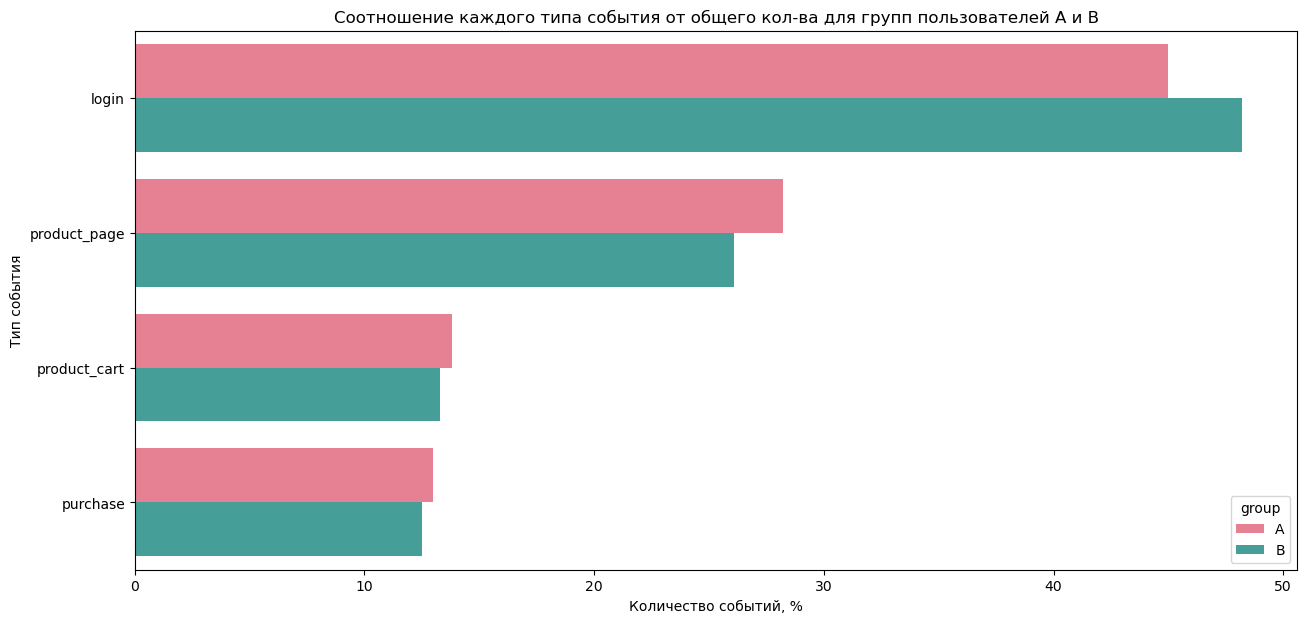

In [46]:
# считаем процент каждого типа события от общего кол-ва
event_name = ab_test_events_14.groupby(['event_name','group']).agg({'user_id': 'count'}).sort_values(by= 'user_id' , ascending=False).reset_index()
event_name.columns = ['event_name', 'group', 'number_actions']

event_name_A = event_name.query('group == "A"')
event_name_A["common_number"] = event_name_A['number_actions'].sum()
event_name_A["proc"] = round(event_name_A['number_actions']/event_name_A["common_number"] * 100, 1)

event_name_B = event_name.query('group == "B"')
event_name_B["common_number"] = event_name_B['number_actions'].sum()
event_name_B["proc"] = round(event_name_B['number_actions']/event_name_B["common_number"] * 100, 1)

event_name_common = pd.concat([event_name_A, event_name_B], axis=0)

# строим гистограмму, отражающую соотношение каждого типа события от общего кол-ва в % для групп пользователей А и В  
plt.figure(figsize = (15,7))
sns.barplot(x='proc', y='event_name', data=event_name_common, hue = 'group', palette= 'husl')
plt.xlabel('Количество событий, %')
plt.ylabel('Тип события')
plt.title('Соотношение каждого типа события от общего кол-ва для групп пользователей А и В')
plt.show()

- **Видно, что пользователи групп А и В примерно однаково проходят по воронке событий к покупке "purchase".**


- **Суть нововведений не ясна, но нужно учитывать, что рекомендательная система может повлиять на переходы между "login" и "product_page" и между "product_page" и "product_cart" т.к. конверсия в переход из одного события в другое выделяется.**

### Распределение количества событий по ДНЯМ, совершаемых активными пользователями обеих групп А и В (относительные величины)

In [47]:
# посмотрим, когда произошло последнее событие
ab_test_events_14['event_dt'].max()

Timestamp('2020-12-29 23:01:38')

- После всех фильтраций исчезли пользователи, совершающие действия в дату '2020-12-30'.

In [48]:
# добавляем информацию о дне (без времени)
ab_test_events_14['event_day'] = ab_test_events_14['event_dt'].dt.date

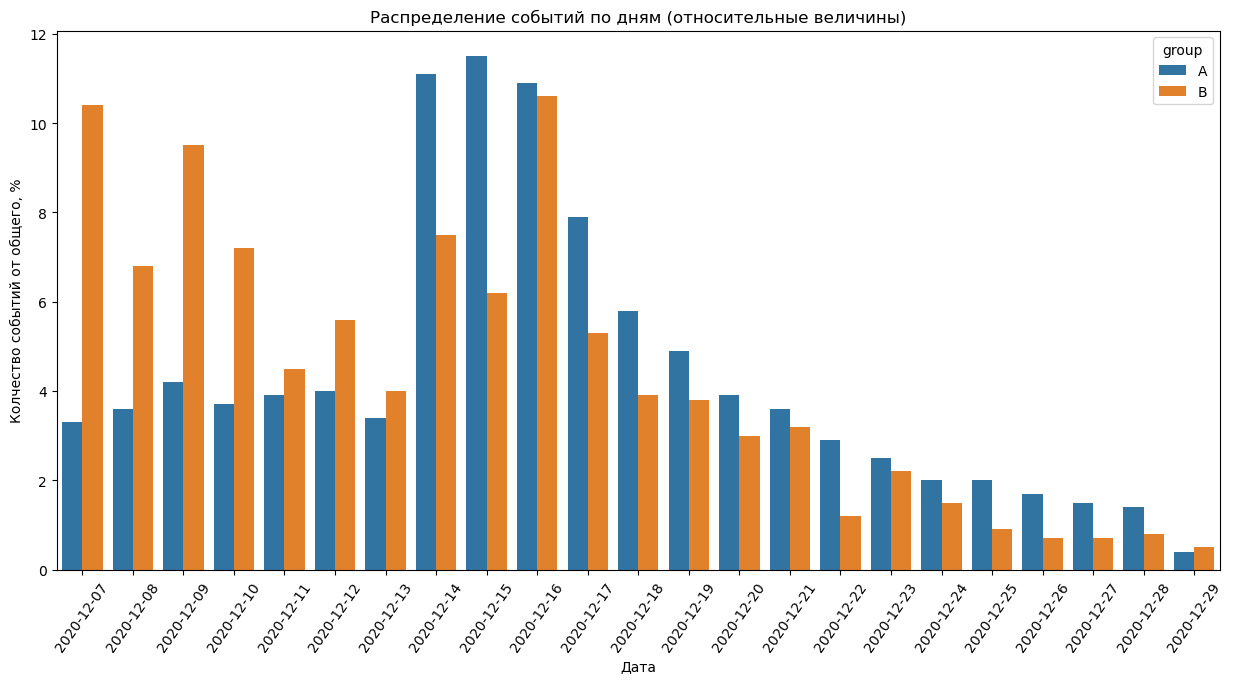

In [49]:
# считаем процент от общего кол-ва событий за каждый день
event_days = ab_test_events_14.groupby(['event_day','group'])[['event_name']].count().reset_index()

event_days_A = event_days.query('group == "A"')
event_days_A["common namber"] = event_days_A["event_name"].sum()
event_days_A["proc"] = round(event_days_A['event_name']/event_days_A["common namber"] * 100, 1)

event_days_B = event_days.query('group == "B"')
event_days_B["common namber"] = event_days_B["event_name"].sum()
event_days_B["proc"] = round(event_days_B['event_name']/event_days_B["common namber"] * 100, 1)

event_days_common = pd.concat([event_days_A, event_days_B], axis=0)
event_days_common

# строим гистограмму распределения количества событий по дням, совершаемых активными пользователями обеих групп А и В (относительные величины)
plt.figure(figsize = (15,7))
sns.barplot(x='event_day', y='proc', data=event_days_common, hue = 'group')
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Колчество событий от общего, %')
plt.xticks(rotation = 55)
plt.title('Распределение событий по дням (относительные величины)')
plt.show()

- **Активность пользователей группы А высокая в середине теста;**


- **Активность пользователей группы B высокая в начале и в середине АБ-теста;**


- **У обоих групп активность идёт на спад к концу теста;**


- **Такое распределение активности может быть связано с сезонными праздниками в регионе EU. В предрождественский период активность неравномерная.**


- **Маркетинговые события, пересекающиеся по времени с AБ-тестом на промежутке от 2020-12-25 до 2020-12-29 не сказываются на количестве событий обеих групп т.к. динамика количества событий по каждой группе практически неизменна.** 

#### Распределение типов событий по ДНЯМ для группы В (абсолютные величины)

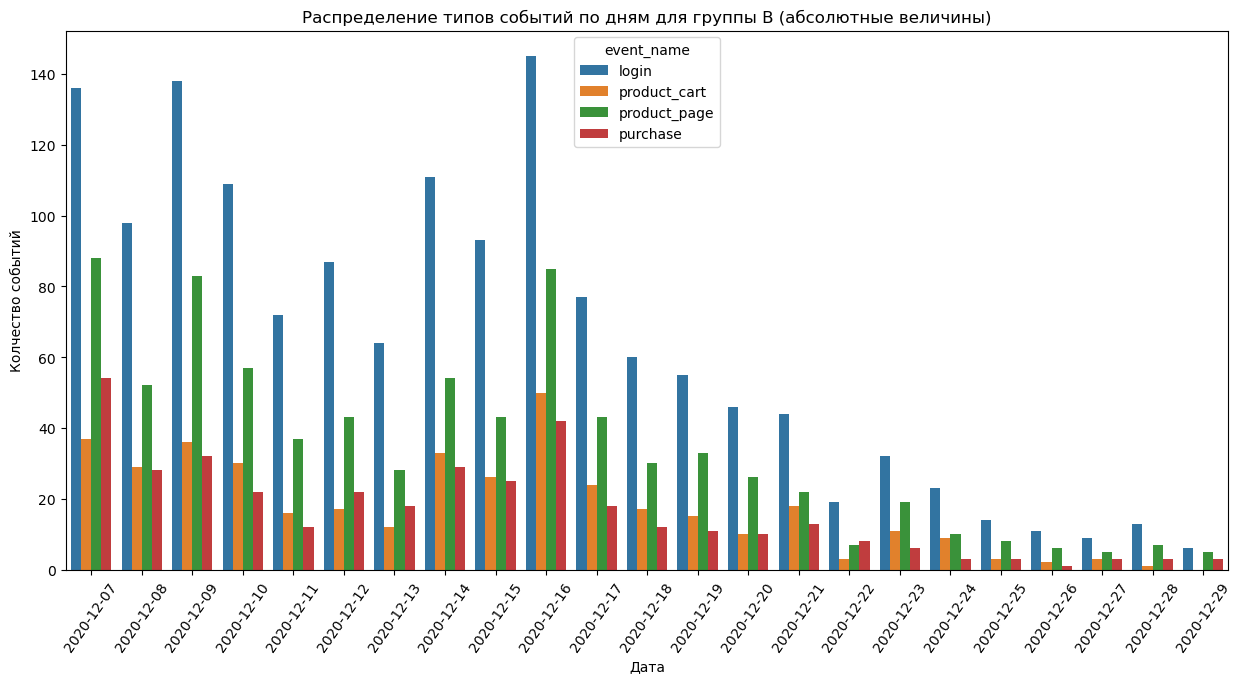

In [50]:
# считаем кол-во всех типов событий по дням для группы В
x = ab_test_events_14.query('group == "B"')

x = x.groupby(['event_day','event_name']).agg({'user_id' :'nunique'}).reset_index()
plt.figure(figsize = (15,7))
sns.barplot(x='event_day', y='user_id', data=x, hue = 'event_name')
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Колчество событий')
plt.xticks(rotation = 55)
plt.title('Распределение типов событий по дням для группы B (абсолютные величины)')
plt.show()

#### Распределение типов событий по ДНЯМ для группы А (абсолютные величины)

In [ ]:
# считаем кол-во всех типов событий по дням для группы В
y = ab_test_events_14.query('group == "A"')

y = y.groupby(['event_day','event_name']).agg({'user_id' :'nunique'}).reset_index()
plt.figure(figsize = (15,7))
sns.barplot(x='event_day', y='user_id', data=y, hue = 'event_name')
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Колчество событий')
plt.xticks(rotation = 55)
plt.title('Распределение типов событий по дням для группы A (абсолютные величины)')
plt.show()

- **Пользователи группы B активно регистрируются в начале и в середине первой половины теста. А пользователей группы А наиболее активно в середине.** 


- **Не обнаружено всплесков каких-то конкрентых событий ОТНОСИТЕЛЬНО остальных по воронке в течение теста у обоих групп. `Судя по всему, в день регистрации пользователи чаще всего и совершают все остальные события по воронке (пользовательская активность в лайфтайме). Наиболее чётко это прослеживается по этапу от "login" до "product_page".`** 


- **Отмечено, что в некоторые дни просмотров корзины "product_cart" получилось меньше чем покупок "purchase", что может означать, что корзина не является обязательным этапом воронки (покупки в 1 клик).**

### Распределение количества событий по ДАТАМ РЕГИСТРАЦИИ,  обеих групп А и В (относительные величины)

In [ ]:
# добавляем информацию о дне (без времени)
ab_test_events_14['regist_day'] = ab_test_events_14['first_date'].dt.date

In [ ]:
# считаем процент от общего кол-ва событий за каждый день
event_regist = ab_test_events_14.groupby(['regist_day','group'])[['event_name']].count().reset_index()

event_regist_A = event_regist.query('group == "A"')
event_regist_A["common namber"] = event_regist_A["event_name"].sum()
event_regist_A["proc"] = round(event_regist_A['event_name']/event_regist_A["common namber"] * 100, 1)

event_regist_B = event_regist.query('group == "B"')
event_regist_B["common namber"] = event_regist_B["event_name"].sum()
event_regist_B["proc"] = round(event_regist_B['event_name']/event_regist_B["common namber"] * 100, 1)

event_regist_common = pd.concat([event_regist_A, event_regist_B], axis=0)

# строим гистограмму распределения количества событий по датам регистрации пользователей, обеих групп А и В (относительные величины)
plt.figure(figsize = (15,7))
sns.barplot(x='regist_day', y='proc', data=event_regist_common, hue = 'group')
plt.xticks(rotation=90)
plt.xlabel('Дата регистрации')
plt.ylabel('Количество событий от общего, %')
plt.xticks(rotation = 55)
plt.title('Распределение событий по датам регистрации (относительные величины)')
plt.show()

- **Самая высокая активность у пользователей группы А, зарегистрировавшихся 14 и 15 декабря. Т.е. можно сказать, что пользователи, зарегистрировавшиеся ближе к концу периода регитрации - наиболее активные на протяжении лайфтайма;**


- **Самая высокая активность у пользователей группы B, зарегистрировавшихся 7, и 16 декабря. Т.е. можно сказать, что пользователи, зарегистрировавшиеся в первый и последний день периода регитрации - наиболее активные на протяжении лайфтайма.**

### Среднее количество действий (за лайфтайм) пользователей, зарегистрировавшихся в разные даты (абсолютные величины)

In [ ]:
# считаем среднее кол-во действий (за период АБ-теста) уник. пользователей, зарегистрировавшихся в разные даты
group_A = ab_test_events_14.query('group == "A"')
mean_action_A = group_A.groupby(['regist_day', 'group']).agg({'user_id' :'nunique', 'event_name':'count'}).reset_index()
mean_action_A['mean_actions'] = round(mean_action_A['event_name']/mean_action_A['user_id'],1)

group_B = ab_test_events_14.query('group == "B"')
mean_action_B = group_B.groupby(['regist_day', 'group']).agg({'user_id' :'nunique', 'event_name':'count'}).reset_index()
mean_action_B['mean_actions'] = round(mean_action_B['event_name']/mean_action_B['user_id'],1)

mean_action_common = pd.concat([mean_action_A, mean_action_B], axis=0)

# строим гистограмму распределения количества событий по датам регистрации пользователей, обеих групп А и В (относительные величины)
plt.figure(figsize = (15,7))
sns.barplot(x='regist_day', y='mean_actions', data=mean_action_common, hue = 'group', palette='hls')
plt.xticks(rotation=90)
plt.xlabel('Дата регистрации')
plt.ylabel('Среднее количество действией')
plt.xticks(rotation = 55)
plt.title('Распределение cреднего количества действий уник. пользователей, зарегистрировавшихся в разные даты')
plt.show()

- **У пользователей группы А, зарегистрировавшихся 11, 13, 14, и 15 декабря, среднее кол-во действий примерно в 1,5 раза выше, чем у группы B (зарег. в те же даты).**


- **В разрезе дат регистраций пользователи группы А совершают в среднем больше действий за лайфтайм, чем пользователи группы B.**

# Выводы по блоку "Исследовательский анализ данных"

- `Активные пользователи теста распределены по группам А и B неравномерно: в процентном соотношении 68/32;`


- `Среднее и медианное кол-во действий, совершаемых пользователи группы А выше, чем у пользователей группы B;`


- Видно, что пользователи групп А и В примерно однаково проходят по воронке событий к покупке "purchase" (в относительных величинах);


- `Суть нововведений не ясна, но нужно учитывать, что рекомендательная система может повлиять на переходы между "login" и "product_page" и между "product_page" и "product_cart" т.к. конверсия в переход из одного события в другое выделяется (достаточно большая разница между этапами);`


- `Общая активность пользователей группы А высокая в середине теста, а группы Б - в начале и в середине;`


- `У обоих групп общая активность идёт на спад к концу теста;`


- `Такое распределение активности может быть связано с сезонными праздниками в регионе EU. В предрождественский период активность неравномерная, что может сказаться на результатах теста;`


- `Маркетинговые события, пересекающиеся по времени с AБ-тестом на промежутке от 2020-12-25 до 2020-12-29 не сказываются на количестве событий обеих групп т.к. динамика количества событий по каждой группе практически неизменна;`


- Не обнаружено всплесков каких-то конкрентых событий ОТНОСИТЕЛЬНО остальных по воронке в течение теста у обоих групп. `Судя по всему, в день регистрации пользователи чаще всего и совершают все остальные события по воронке (пользовательская активность в лайфтайме). Наиболее чётко это прослеживается по этапу от "login" до "product_page";


- Отмечено, что в некоторые дни просмотров корзины "product_cart" получилось меньше чем покупок "purchase", что может означать, что корзина не является обязательным этапом воронки (покупки в 1 клик).


- Самая высокая активность у пользователей группы А, зарегистрировавшихся 14 и 15 декабря. `Т.е. можно сказать, что пользователи, зарегистрировавшиеся ближе к концу периода регитрации - наиболее активные на протяжении лайфтайма;`


- Самая высокая активность у пользователей группы B, зарегистрировавшихся 7 и 16 декабря. `Т.е. можно сказать, что пользователи, зарегистрировавшиеся в первый и последний день периода регитрации - наиболее активные на протяжении лайфтайма.`


- У пользователей группы А, зарегистрировавшихся 11, 13, 14, и 15 декабря, среднее кол-во действий примерно в 1,5 раза выше, чем у группы B (зарег. в те же даты).

## Продуктовая воронка

In [ ]:
# Построим таблицу с кол-вом уник. пользователей на каждом шаге воронки событий: "login, product_page, product_cart, purchase"
funnel_A = ab_test_events_14.query('group == "A"')
funnel_A = funnel_A.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by= 'user_id' , ascending=False).reset_index()
funnel_A.columns = ['event_name', 'group_A']

funnel_B = ab_test_events_14.query('group == "B"')
funnel_B = funnel_B.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by= 'user_id' , ascending=False).reset_index()
funnel_B.columns = ['event_name', 'group_B']

funnel_common = funnel_B.merge(funnel_A, on = 'event_name')
funnel_common

- **У группы А просмотров корзины 'product_cart' получилось меньше чем покупок 'purchase'. Это может означать, что корзина не является обязательным этапом воронки (покупки в 1 клик).**

In [ ]:
# Построим воронку событий группы А
fig = go.Figure(go.Funnel(y = ['login', 'product_page', 'product_cart', 'purchase'], x = funnel_A['group_A'], marker = {"color": ["silver", "wheat", "blue", "lightsalmon"]}, textinfo = "value + percent initial + percent previous"))
fig.update_layout(title = 'Воронка событий группы А')
fig.show()

In [ ]:
# Построим воронку событий группы B
fig = go.Figure(go.Funnel(y = ['login', 'product_page', 'product_cart', 'purchase'], x = funnel_B['group_B'], marker = {"color": ["silver", "wheat", "blue", "tan"]}, textinfo = "value + percent initial + percent previous"))
fig.update_layout(title = 'Воронка событий группы B')
fig.show()

- **Не достигнут ожидаемый эффект ни на одном этапе воронки: за 14 дней с момента регистрации пользователи группы B не показали минимальное улучшение конверсии - 10%;**


- **Конверсия из 'login' в 'product_page' у групп А и B: 63% и 56%, соответственно;**


- **Конверсия из 'product_page' в 'product_cart' у групп А и B: 48% и 50%, соответственно;**


- **Конверсия из 'product_cart' в 'purchase' у групп А и B одинаковая: 98% и 99%, соответственно;**


- **Конверсия в покупку у групп А и B различается незначительно: 30% и 28%, соответственно.**

**`Обнаруженные особенности данных, которые могут негативно влиять на точность теста:`**

- **Активные пользователи теста распределены по группам А и B неравномерно. Выборки группы B в 2,5 - 3 раза меньше выборок группы А, что может увеличивать погрешность теста.**


- **Время проведения теста совпадает с маркетинговыми и другими активностями (втч. рождественские праздники), что влияет на активность пользователей и результаты АБ-теста в целом. Некорректно оценивать нововведения в периоды, сильно меняющие активность.**

## Статистический тест

**Проверяем гипотезу о равенстве выборок групп A и B на каждом этапе воронки при помощи Z-критерия;**

**Проверяем разницу в конверсии от начального этапа воронки;**

**Cравниваем пропорции двух генеральных совокупностей по выборкам из них.**

- `Нулевая гипотеза: 'Нет статистически значимых различий в доле уникальных пользователей, прошедших через воронку'`


- `Альтернативная гипотеза: 'Есть статистически значимые различия в доле уникальных пользователей, прошедших через воронку'`

    
- `За уровень значимости примем: alpha = 0.05`

In [ ]:
# подготовим данные для проведения z-теста
funnel_test = funnel_common.query('event_name != "login"')
funnel_test

funnel_login = funnel_common.query('event_name == "login"')
funnel_login_B = funnel_login.iloc [0]['group_B']
funnel_login_A = funnel_login.iloc [0]['group_A']

In [ ]:
# Проверяем, находят ли статистические критерии разницу между выборками групп А и B на каждом этапе воронки

alpha = 0.01  # критический уровень статистической значимости
def z_test(group_A, group_B):
    for i in funnel_test.index:
        p1 = funnel_test[group_A][i] / funnel_login_A # пропорция успехов в первой группе 'A'
      
        p2 = funnel_test[group_B][i] / funnel_login_B # пропорция успехов во второй группе 'B'
        
        p_combined = ((funnel_test[group_A][i] + funnel_test[group_B][i]) / (funnel_login_A + funnel_login_B)) # пропорция успехов в комбинированном датасете:
       
        difference = p1 - p2   # разница пропорций в датасетах
       
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/funnel_login_A + 1/funnel_login_B)) # считаем статистику в ст.отклонениях стандартного нормального распределения
      

        distr = st.norm(0, 1)  # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('{} p-значение: {}'.format(funnel_test['event_name'][i], p_value))
        
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        

z_test('group_A', 'group_B')

- Статистически значимых различий между контрольной и экспериментальной группами A и B НЕТ на всех этапах воронки, `кроме первого этапа: из 'login' в 'product_page'.`

# Общие выводы

**`Тест проведён не корректно по многим пунктам ТЗ:`**

- Неверная дата остановки теста: '2020-12-30 23:36:33' (верная дата согласно ТЗ: 2020-01-04);


- В связи с чем, установлена корректная дата остановки набора пользователей -  "2020-12-17 23:36:33" в соответствии с horizon_days = 14 (верная дата согласно ТЗ: 2020-12-21);


- В тест отобрано 13,2% пользователей из региона EU (ожидаемое кол-во согласно ТЗ: 15%);


- В тест попали пользователи из других регионов: N.America, APAC и CIS. Оставили только пользователей, которые из региона EU;


- Процент активных пользователей, участвующих в тесте "recommender_system_test", от ожидаемого кол-ва 6000 : 27.9%;


- Период проведения теста 'recommender_system_test' пересекается с 2мя маркетинговыми событиями: 'Christmas&New Year Promo' и 'CIS New Year Gift Lottery'. Но они, к счастью, не сказываются на количестве событий обеих групп т.к. динамика количества событий по каждой группе практически неизменна;


- Обнаружены дублирующиеся пользователи в ЭКСПЕРИМЕНТАЛЬНЫХ группах обоих тестов 'recommender_system_test' и 'interface_eu_test'. Этих пользователей удалили т.к. невозможно выявить, какое из 2ух экспериментальных нововведний повлияло на конверсию;


-  Обнаружены дублирующиеся пользователи, участвующие в экспериментальной группе теста 'interface_eu_test' и контрольной группе - 'recommender_system_test одновременно. Этих пользователей удалили т.к. такие пользователи в группе А нашего теста "не чистые" и видят какие-то нововведения;'


- Обнаружены дублирующиеся пользователи, участвующие в КОНТРОЛЬНЫХ группах обоих тестов 'recommender_system_test' и 'interface_eu_test'. Не стали их удалять т.к. пользователи из контрольных групп обоих тестов не видят никаких изменений и поэтому их пользовательская активность не должна измениться;

**`Результаты проведения исследовательского анализа данных:`** 

- **Активные пользователи теста распределены по группам А и B неравномерно: в процентном соотношении 68% / 32%;**


- **Среднее и медианное кол-во действий, совершаемых пользователями группы А выше, чем у пользователей группы B;**


- Общая активность пользователей группы А высокая в середине теста, а группы Б - в начале и в середине. У обоих групп общая активность идёт на спад к концу теста. **Такое распределение активности может быть связано с сезонными праздниками в регионе EU. В предрождественский период активность неравномерная, что может сказаться на результатах теста;**


- Не обнаружено всплесков каких-то конкрентых событий ОТНОСИТЕЛЬНО остальных по воронке в течение теста у обоих групп. **Судя по всему, в день регистрации пользователи чаще всего и совершают все остальные события по воронке (пользовательская активность в лайфтайме);**


- **Не достигнут ожидаемый эффект ни на одном этапе воронки: за 14 дней с момента регистрации пользователи группы B не показали минимальное улучшение конверсии - 10%**:

  - Конверсия из 'login' в 'product_page' у групп А и B: 63% и 56%, соответственно;

  - Конверсия из 'product_page' в 'product_cart' у групп А и B: 48% и 50%, соответственно;
 
  - Конверсия из 'product_cart' в 'purchase' у групп А и B одинаковая: 98% и 99%, соответственно.


- **Конверсия в покупку у групп А и B различается незначительно: 30% и 28%, соответственно.**

**`Обнаруженные особенности данных, которые могут негативно влиять на точность стат.теста:`**
    
- **Активные пользователи теста распределены по группам А и B неравномерно. Выборки группы B в 2,5 - 3 раза меньше выборок группы А, что может увеличивать погрешность теста.** 


- **Время проведения теста совпадает с маркетинговыми и другими активностями (втч. рождественские праздники), что влияет на активность пользователей и результаты АБ-теста в целом. Некорректно оценивать нововведения в периоды, сильно меняющие активность.**

**`Оценка результатов A/B-тестирования:`**

- **Статистически значимые различия ЕСТЬ на первом этапе воронки: из 'login' в 'product_page'.** На остальных этапах стат. значимых различий нет. 


- **Улучшенная рекомендательная система не показала ожидаемый эффект ни на одном этапе воронки: за 14 дней с момента регистрации пользователи группы B не показали минимальное улучшение конверсии - 10%. Конверсия из 'login' в 'product_page' снизилась.**


- **АБ-тест проведён не корректно, что могло повлиять на конечный результат.**  

# Рекомендации

1. При некорректно проведённом АБ-тесте, результаты исследования показали, что улучшенная рекомендательная система оказала негативный эффект на этап воронки: из 'login' в 'product_page'.


2. Нужно либо не применять тестируемые нововведения, либо корректно провести АБ-тест, в результате чего данные будут соотвествовать:


- Пунктам ТЗ;

- Время проведения теста не совпадает с маркетинговыми и другими активностями (втч. рождественские праздники и другие);

- Аудитория теста не пересекается с аудиторией конкурирующего теста и равномерно распределена по тестовым группам.